In [35]:
# Name: Sai Anish Garapati
# UIN: 650208577

## Importing required Libraries

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
from PIL import Image

## Custom Dataset Class

In [37]:
class TrafficImageDatset(Dataset):
	def __init__(self, csv_file, root_dir, transform=None):
		self.csv_content = pd.read_csv(csv_file, usecols=['ClassId', 'Path'])
		self.root_dir = root_dir
		self.transform = transform

	def __len__(self):
		return len(self.csv_content)
	
	def __getitem__(self, index):
		img = Image.open(self.root_dir + self.csv_content.iloc[index, 1])
		label = torch.tensor(int(self.csv_content.iloc[index, 0]))

		if self.transform:
			img_tensor = self.transform(img)
		
		return (img_tensor, label)


## Neural Network Model (CNN)

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 43)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Training Function

In [39]:
def train_model(device, model, train_loader, optimizer, epoch, batch_size):
    model.train()
    tot_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, label)
        loss.backward()
        optimizer.step()

        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(label.view_as(predictions)).sum().item()
        tot_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.0 * batch_idx /
                len(train_loader), tot_loss / (batch_idx + 1),
                100.0 * correct / ((batch_idx + 1) * batch_size)))
    print('End of Epoch: {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(
        tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)))

    return tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)

## Validation Function

In [40]:
def validation_model(device, model, validation_loader, batch_size):
    model.eval()
    tot_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(validation_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            tot_loss += torch.nn.CrossEntropyLoss()(output, label).item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(label.view_as(predictions)).sum().item()

    print('Validation Loss: {:.6f}, Validation Accuracy: {:.2f}%'.format(
        tot_loss / len(validation_loader),
        100.0 * correct / (len(validation_loader) * batch_size)
    ))

    return tot_loss/len(validation_loader), 100.0 * correct / (len(validation_loader) * batch_size)

## Loading Dataset using Dataloader and preprocessing

Train Epoch: 1 [0/33327 (0%)]	Loss: 3.754114, Accuracy: 1.00%
Train Epoch: 1 [10000/33327 (30%)]	Loss: 2.879000, Accuracy: 21.55%
Train Epoch: 1 [20000/33327 (60%)]	Loss: 2.203291, Accuracy: 36.84%
Train Epoch: 1 [30000/33327 (90%)]	Loss: 1.749246, Accuracy: 48.96%
End of Epoch: 1
Training Loss: 1.636217, Training Accuracy: 52.01%
Validation Loss: 0.534228, Validation Accuracy: 82.98%
Train Epoch: 2 [0/33327 (0%)]	Loss: 0.555133, Accuracy: 81.00%
Train Epoch: 2 [10000/33327 (30%)]	Loss: 0.502214, Accuracy: 84.63%
Train Epoch: 2 [20000/33327 (60%)]	Loss: 0.431743, Accuracy: 86.86%
Train Epoch: 2 [30000/33327 (90%)]	Loss: 0.386107, Accuracy: 88.27%
End of Epoch: 2
Training Loss: 0.375073, Training Accuracy: 88.42%
Validation Loss: 0.204804, Validation Accuracy: 94.92%
Train Epoch: 3 [0/33327 (0%)]	Loss: 0.225849, Accuracy: 95.00%
Train Epoch: 3 [10000/33327 (30%)]	Loss: 0.215437, Accuracy: 93.60%
Train Epoch: 3 [20000/33327 (60%)]	Loss: 0.207746, Accuracy: 93.86%
Train Epoch: 3 [30000/33

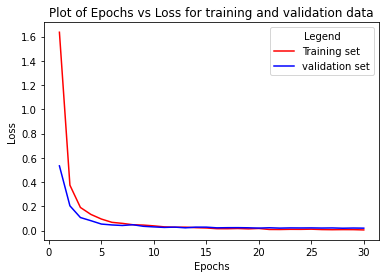

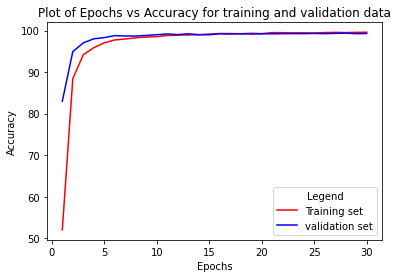

In [57]:
torch.manual_seed(2021)
root_path = '../../../../ML_Project_Data/'
train_batch_size = 100
validation_batch_size = 100
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = TrafficImageDatset(csv_file=root_path + 'Train.csv', root_dir = root_path, transform=transform)

training_length = int(0.85 * len(train_dataset))
validation_length = len(train_dataset) - training_length

train_set, validation_set = torch.utils.data.random_split(train_dataset, [training_length, validation_length])

train_loader = DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=validation_batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(0, 30):
    loss, accuracy = train_model(device, model, train_loader, optimizer, epoch + 1, train_batch_size)
    training_loss.append(loss)
    training_accuracy.append(accuracy)

    loss, accuracy = validation_model(device, model, validation_loader, validation_batch_size)
    validation_loss.append(loss)
    validation_accuracy.append(accuracy)

    scheduler.step()

%matplotlib inline
plt.title('Plot of Epochs vs Loss for training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(list(range(1, len(training_loss) + 1)), training_loss, 'r', label='Training set')
plt.plot(list(range(1, len(validation_loss) + 1)), validation_loss, 'b', label='validation set')
plt.legend(title='Legend')
plt.show()

plt.title('Plot of Epochs vs Accuracy for training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(training_loss) + 1)), training_accuracy, 'r', label='Training set')
plt.plot(list(range(1, len(validation_loss) + 1)), validation_accuracy, 'b', label='validation set')
plt.legend(title='Legend')
plt.show()

torch.save(model.state_dict(), 'ML_Model.pt')